In [1]:
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.stats
from collections import defaultdict
from visualisation_utils import VisualisationUtils

utils = VisualisationUtils()
sns.set_style("white")
sns.set_context("talk")

### Section 3.2: control setup

In [2]:
gradients = pickle.load(open("pickled_results/gradient_testing.pickle", 'rb'))
probing = pickle.load(open("pickled_results/probing_control.pickle", 'rb'))
layer_swapping = pickle.load(open("pickled_results/swapping_control.pickle", 'rb'))
layer_retraining = pickle.load(open("pickled_results/retraining_control.pickle", 'rb'))


def load(dicts):
    x, accuracy1, accuracy2, d, m = [], [], [], [], []
    for name, dict_ in dicts.items():
        for modeln in ["BERT", "Pythia", "GPT-N", "OPT"]:
            for  dataset in utils.control_setup_ds_names:
                if (modeln, dataset) in dict_:
                    x.append(name)
                    d.append(utils.capitalise(dataset))
                    m.append(modeln)
                    accuracy1.append(dict_[(modeln, dataset)]["accuracy@1" ])
                    accuracy2.append(dict_[(modeln, dataset)]["accuracy@2" ])

    return x, accuracy1, accuracy2, d, m

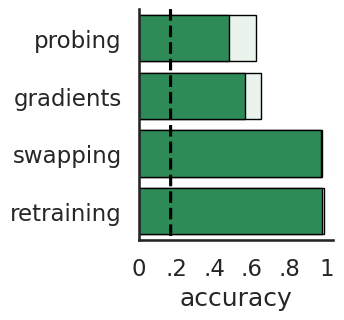

In [3]:
x, accuracy1, accuracy2, d, m = load(
    {"probing": probing, "gradients": gradients, "swapping": layer_swapping, "retraining": layer_retraining})

plt.figure(figsize=(2.5, 3))
ax = sns.barplot(y=x + x, x=accuracy1 + accuracy2, orient='h', hue=["a@1"] * len(x) + ["a@2"]*len(x), errorbar=None,
                 linewidth=1, edgecolor="black", saturation=1, palette=sns.light_palette("seagreen", 2), dodge=False)
#ax = sns.barplot(y=x, x=accuracy2, orient='h', linewidth=1, edgecolor="black", saturation=1, color=c)
ax.set_ylim(3.5, -0.5)

sns.lineplot(x=[0.167, 0.168], y=[-0.5, 3.5], color='black', linestyle='--')
sns.despine(right=True, top=True)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, ".2", ".4", ".6", ".8", 1])
plt.xlabel("accuracy")
plt.legend([], [], frameon=False)
plt.savefig("summarising_visualisations/accuracy_pertechnique.pdf", bbox_inches="tight")
plt.show()

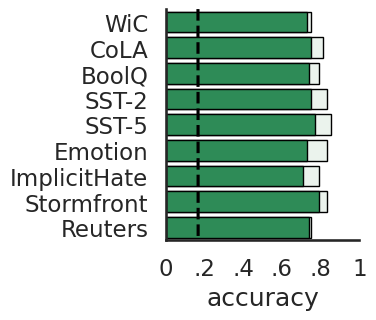

In [4]:
plt.figure(figsize=(2.5, 3))
ax = sns.barplot(y=d+d, x=accuracy1+accuracy2, orient='h', hue=["a@1"] * len(x) + ["a@2"]*len(x),
                 linewidth=1, edgecolor="black", saturation=1, dodge=False, errorbar=None,
                 palette=sns.light_palette("seagreen", 2))
ax.set_ylim(8.5, -0.5)
sns.lineplot(x=[0.167, 0.168], y=[-0.5, 9.5], color='black', linestyle='--')

sns.despine(right=True, top=True)
plt.xlabel("accuracy")
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, ".2", ".4", ".6", ".8", 1])
plt.legend([],[],frameon=False)
plt.savefig("summarising_visualisations/accuracy_perdataset.pdf", bbox_inches="tight")
plt.show()

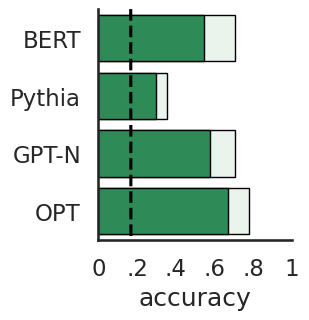

In [5]:
x, accuracy1, accuracy2, d, m = load(
    {"probing": probing, "gradients": gradients})

plt.figure(figsize=(2.5, 3))
ax = sns.barplot(y=m +m, x=accuracy1 + accuracy2, orient='h', hue=["a@1"] * len(x) + ["a@2"]*len(x),
                 palette=sns.light_palette("seagreen", 2),
                 errorbar=None,
                 linewidth=1, edgecolor="black", saturation=1, dodge=False)
sns.lineplot(x=[0.167, 0.168], y=[-0.5, 3.5], color='black', linestyle='--')
ax.set_ylim(3.5, -0.5)
sns.despine(right=True, top=True)
plt.xlabel("accuracy")
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, ".2", ".4", ".6", ".8", 1])

plt.legend([],[],frameon=False)
plt.savefig("summarising_visualisations/accuracy_permodel.pdf", bbox_inches="tight")
plt.show()

### Section 4: heatmaps correlating M-CoG and per-layer weights

In [2]:
swapping_full, swapping = pickle.load(open("pickled_results/swapping_main.pickle", 'rb'))
probing_full, probing = pickle.load(open("pickled_results/probing_main.pickle", 'rb'))
retraining_full, retraining = pickle.load(open("pickled_results/retraining_main.pickle", 'rb'))
gradients_full, gradients = pickle.load(open("pickled_results/gradients_main.pickle", 'rb'))

#### Correlations among techniques, using the M-Cog coefficients

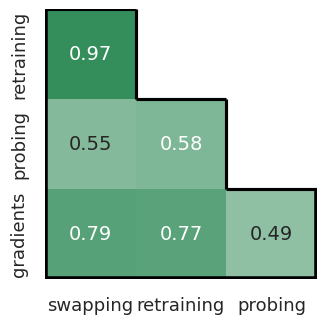

In [3]:
plt.figure(figsize=(3.5, 3.5))
matrix = np.zeros((4, 4))
matrix2 = np.zeros((4, 4)).tolist()
for i, res in enumerate([swapping, retraining, probing, gradients]):
    for j, res2 in enumerate([swapping, retraining, probing, gradients]):
        x, y = [], []
        for m1 in res:
            x.extend([res[m1][d] for d in utils.ds_names])
            y.extend([res2[m1][d] for d in utils.ds_names])
        r, p = scipy.stats.pearsonr(x, y)
        matrix[i, j] = r
        matrix2[i][j] = f"{r:.2f}{'*' if p > 0.05 else ''}"
mask = np.triu(matrix)
ax = sns.heatmap(
    matrix[1:,:-1], annot=[z[:-1] for z in matrix2[1:]], cbar=False, vmin=0, vmax=1,
    annot_kws={'fontsize': 14},
    cmap=sns.light_palette("seagreen", as_cmap=True),
    mask=mask[1:,:-1], fmt='')
utils.plot_lines(ax)
ax.set_xticklabels(["swapping", "retraining", "probing"], fontsize=13)
ax.set_yticklabels(["retraining", "probing", "gradients"], fontsize=13)
plt.savefig("summarising_visualisations/corrs_techniques_mcog.pdf", bbox_inches='tight')

#### Correlations among techniques, using the layer-wise weights

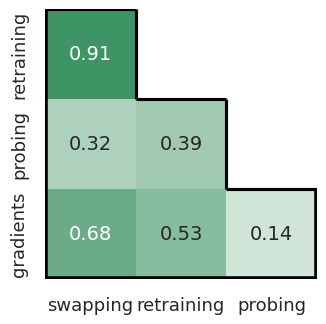

In [4]:
plt.figure(figsize=(3.5, 3.5))
matrix = np.zeros((4, 4))
matrix2 = np.zeros((4, 4)).tolist()
for i, res in enumerate([swapping_full, retraining_full, probing_full, gradients_full]):
    for j, res2 in enumerate([swapping_full, retraining_full, probing_full, gradients_full]):
        x, y, w = [], [], []
        for m1 in res:
            x.extend([k for d in utils.ds_names for k in res[m1][d]])
            y.extend([k for d in utils.ds_names for k in res2[m1][d]])
        r, p = scipy.stats.pearsonr(x, y)
        matrix[i, j] = r
        matrix2[i][j] = f"{r:.2f}{'*' if p > 0.05 else ''}"
mask = np.triu(matrix)
ax = sns.heatmap(
    matrix[1:,:-1], annot=[z[:-1] for z in matrix2[1:]], cbar=False, vmin=0, vmax=1,
    annot_kws={'fontsize': 14},
    cmap=sns.light_palette("seagreen", as_cmap=True),
    mask=mask[1:,:-1], fmt='')
utils.plot_lines(ax)
ax.set_xticklabels(["swapping", "retraining", "probing"], fontsize=13)
ax.set_yticklabels(["retraining", "probing", "gradients"], fontsize=13)
plt.savefig("summarising_visualisations/corrs_techniques_full.pdf", bbox_inches='tight')

#### Correlations among models, using the M-CoG coefficients

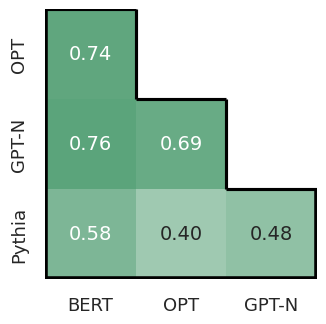

In [5]:
plt.figure(figsize=(3.5, 3.5))
matrix = np.zeros((4, 4))
matrix2 = np.zeros((4, 4)).tolist()
for i, m1 in enumerate(["bert-base-cased", "facebook_opt-125m", "EleutherAI_gpt-neo-125m", "EleutherAI_pythia-160m-deduped"]):
    for j, m2 in enumerate(["bert-base-cased", "facebook_opt-125m", "EleutherAI_gpt-neo-125m", "EleutherAI_pythia-160m-deduped"]):
        x, y, = [], []
        for technique in [swapping, retraining, probing, gradients]:
            x.extend([technique[m1][d] for d in utils.ds_names])
            y.extend([technique[m2][d] for d in utils.ds_names])
        r, p = scipy.stats.spearmanr(x, y)
        matrix[i, j] = r
        matrix2[i][j] = f"{r:.2f}{'*' if p > 0.05 else ''}"
mask = np.triu(matrix)
ax = sns.heatmap(
    matrix[1:,:-1], annot=[z[:-1] for z in matrix2[1:]], cbar=False, vmin=0, vmax=1,
    annot_kws={'fontsize': 14},
    cmap=sns.light_palette("seagreen", as_cmap=True),
    mask=mask[1:,:-1], fmt='')
utils.plot_lines(ax)
ax.set_yticklabels(["OPT", "GPT-N", "Pythia"], fontsize=13)
ax.set_xticklabels(["BERT", "OPT", "GPT-N"], fontsize=13)
plt.savefig("summarising_visualisations/corrs_models_mcog.pdf", bbox_inches='tight')

#### Correlations among models, using the layer-wise weights

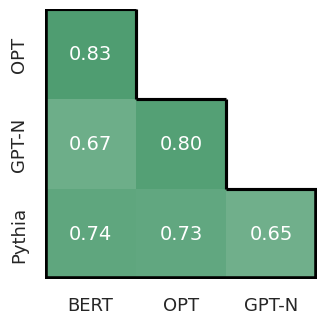

In [6]:
plt.figure(figsize=(3.5, 3.5))
matrix = np.zeros((4, 4))
matrix2 = np.zeros((4, 4)).tolist()
for i, m1 in enumerate(["bert-base-cased", "facebook_opt-125m", "EleutherAI_gpt-neo-125m", "EleutherAI_pythia-160m-deduped"]):
    for j, m2 in enumerate(["bert-base-cased", "facebook_opt-125m", "EleutherAI_gpt-neo-125m", "EleutherAI_pythia-160m-deduped"]):
        x, y = [], []
        for technique,n in [(swapping_full, "swapping"), (retraining_full, "retraining"),
                            (probing_full, "probing"), (gradients_full, "gradients")]:
            x.extend(utils.minmax([k for d in utils.ds_names for k in technique[m1][d]]))
            y.extend(utils.minmax([k for d in utils.ds_names for k in technique[m2][d]]))
        r, p = scipy.stats.spearmanr(x, y)
        matrix[i, j] = r
        matrix2[i][j] = f"{r:.2f}{'*' if p > 0.05 else ''}"
mask = np.triu(matrix)
ax = sns.heatmap(
    matrix[1:,:-1], annot=[z[:-1] for z in matrix2[1:]], cbar=False,
    annot_kws={'fontsize': 14},
    cmap=sns.light_palette("seagreen", as_cmap=True), vmin=0, vmax=1,
    mask=mask[1:,:-1], fmt='')
utils.plot_lines(ax)
ax.set_yticklabels(["OPT", "GPT-N", "Pythia"], fontsize=13)
ax.set_xticklabels(["BERT", "OPT", "GPT-N"], fontsize=13)
plt.savefig("summarising_visualisations/corrs_models_full.pdf", bbox_inches='tight')

### Section 4: summary of M-CoG coefficients

#### M-CoG per dataset, per technique (averaged over models)

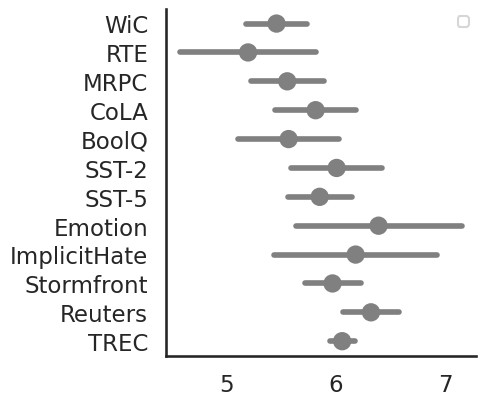

In [8]:
plt.figure(figsize=(4,  4.5))
sns.set_style("white")

def load(dicts):
    datasets, mcog, models = [], [], []
    for name, dict_ in dicts:
        for i, d in enumerate(utils.ds_names):
            datasets.append(utils.capitalise(d))
            mcog.append(np.mean([dict_[m][d] for m in dict_]))
            models.append(name)
    return datasets, mcog, models

datasets, mcog, models = load([
    ("layer retraining", retraining),
    ("layer swapping", swapping),
    ("probing", probing),
    ("gradients", gradients)])

plt.yticks(range(0, 12))
ax = sns.pointplot(x=mcog, y=datasets, orient='h', join=False, color='grey', errorbar='sd')
ax = sns.swarmplot(x=mcog, y=datasets, hue=models, palette='viridis',
                   s=7, orient='h', edgecolor='black', linewidth=1)
h, l = ax.get_legend_handles_labels()
plt.legend(h, l, fontsize=10)
plt.ylim(11.5, -0.5)
ax.set_xticks([4, 5, 6], [5, 6, 7])
sns.despine()
plt.savefig("summarising_visualisations/cog_techniques.pdf", bbox_inches="tight")

#### M-CoG per dataset, per model (averaged over techniques)

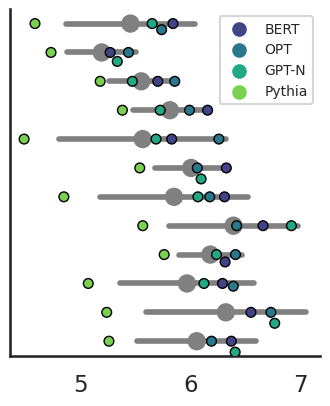

In [12]:
plt.figure(figsize=(4,  4.5))
datasets, mcog, models = [], [], []
for m in swapping:
    for i, d in enumerate(utils.ds_names):
        datasets.append(d)
        mcog.append(np.mean([swapping[m][d], probing[m][d], retraining[m][d], gradients[m][d]]))
        models.append(utils.shorten(m))

plt.yticks(range(0, 12))
ax = sns.pointplot(x=mcog, y=datasets, orient='h', join=False, color='grey', errorbar='sd')
ax = sns.swarmplot(
    x=mcog, y=datasets, hue=models, palette='viridis',
    s=7, orient='h', edgecolor='black', linewidth=1)

h, l = ax.get_legend_handles_labels()
plt.legend(h[:4], l[:4], fontsize=10)
plt.ylim(11.5, -0.5)
sns.despine()
ax.set_yticklabels([])
ax.set_xticks([4, 5, 6], [5, 6, 7])

plt.savefig("summarising_visualisations/cog_models.pdf", bbox_inches="tight")

#### Store M-CoG to file, to use in section 5 (centroid analysis)

In [13]:
mcog = defaultdict(lambda: dict())
for i, d in enumerate(utils.ds_names):
    for m in swapping:
        mcog[utils.shorten(m)][d] = np.mean([swapping[m][d], probing[m][d], retraining[m][d], gradients[m][d]])
pickle.dump(dict(mcog), open("pickled_results/mcog_summary.pickle", 'wb'))